# Predviđanje otkazivanja hotelskih rezervacija

## 1. Učitavanje podataka 

U eksploratornoj analizi smo proučili kakvim podacima raspolažemo, te smo shodno tome uveli neke nove varijable, te smo popunili null vrijednosti. Zamijenili smo neke od originalnih numeričkih varijabli binarnim kategorijalnim varijablama kako bi učinili model općenitijim. Primjer toga je nova varijabla is_children koja nam samo govori ima li djece, ali ne i koliko djece u svakoj rezervaciji.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score , roc_curve, auc, classification_report
from sklearn.naive_bayes import GaussianNB

In [2]:
df=pd.read_csv("hotel_bookings.csv")

In [3]:
##Izbacimo redove u kojima su rezervacije sa 0 osoba
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)
## Zamjenimo null vrijednosti s 0 za agent, company i children.
df[['agent','company', 'children']] = df[['agent','company', 'children']].fillna(0.0)
## Tamo gdje nema vrijednosti za country, zamjenimo sa mode
df['country'].fillna(df.country.mode().to_string(), inplace=True)

In [4]:
##Stvaramo nove varijable iz postojećih da lakše analiziramo odnose
df['is_children'] = ['1' if x > 0 else '0' for x in df['children']]
df['is_baby'] = ['1' if x > 0 else '0' for x in df['babies']]
df['is_agent'] = ['1' if x > 0 else '0' for x in df['agent']]
df['is_company'] = ['1' if x > 0 else '0' for x in df['company']]
df['is_parking'] = ['1' if x > 0 else '0' for x in df['required_car_parking_spaces']]
df['is_request'] = ['1' if x > 0 else '0' for x in df['total_of_special_requests']]
df['is_canceled_before'] = ['1' if x > 0 else '0' for x in df['previous_cancellations']]
df['is_changed'] = ['1' if x > 0 else '0' for x in df['booking_changes']]
df['is_waited'] = ['1' if x > 0 else '0' for x in df['days_in_waiting_list']]
df['is_room_changed'] = df[['reserved_room_type','assigned_room_type']].apply(lambda x:x['reserved_room_type'] != x['assigned_room_type'], axis=1)

In [5]:
rh = df.loc[(df["hotel"] == "Resort Hotel")]
ch = df.loc[(df["hotel"] == "City Hotel")]

In [6]:
df1 = df.drop(columns = ['babies', 'children', 'agent', 'company', 'required_car_parking_spaces', 'total_of_special_requests', 'previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'assigned_room_type'])

## 2. Feature Engineering

Da bismo proučavali korelaciju kategorijskih varijabli moramo napraviti 'encoding' nad njima. Napraviti ćemo ga koristeći LableEncoder.

In [7]:
df_le = df1.copy()
le = LabelEncoder()

categoricals = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'deposit_type',
    'customer_type',
    'reservation_status',
    'is_children',
    'is_baby',
    'is_agent',
    'is_company',
    'is_parking',
    'is_request',
    'is_canceled_before',
    'is_waited',
    'is_changed',
    'is_room_changed'
]

for col in categoricals:
    df_le[col] = le.fit_transform(df_le[col])

In [8]:
df_le.corr()["is_canceled"].sort_values(ascending = False )

is_canceled                       1.000000
deposit_type                      0.468676
lead_time                         0.292876
country                           0.272496
is_canceled_before                0.271021
distribution_channel              0.167707
is_agent                          0.102218
is_waited                         0.099211
market_segment                    0.059419
adults                            0.058182
adr                               0.046492
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_month               -0.001269
stays_in_weekend_nights          -0.001323
is_children                      -0.003954
arrival_date_day_of_month        -0.005948
meal                             -0.017227
is_baby                          -0.034388
previous_bookings_not_canceled   -0.057365
reserved_room_type               -0.062216
customer_type                    -0.068206
is_repeated

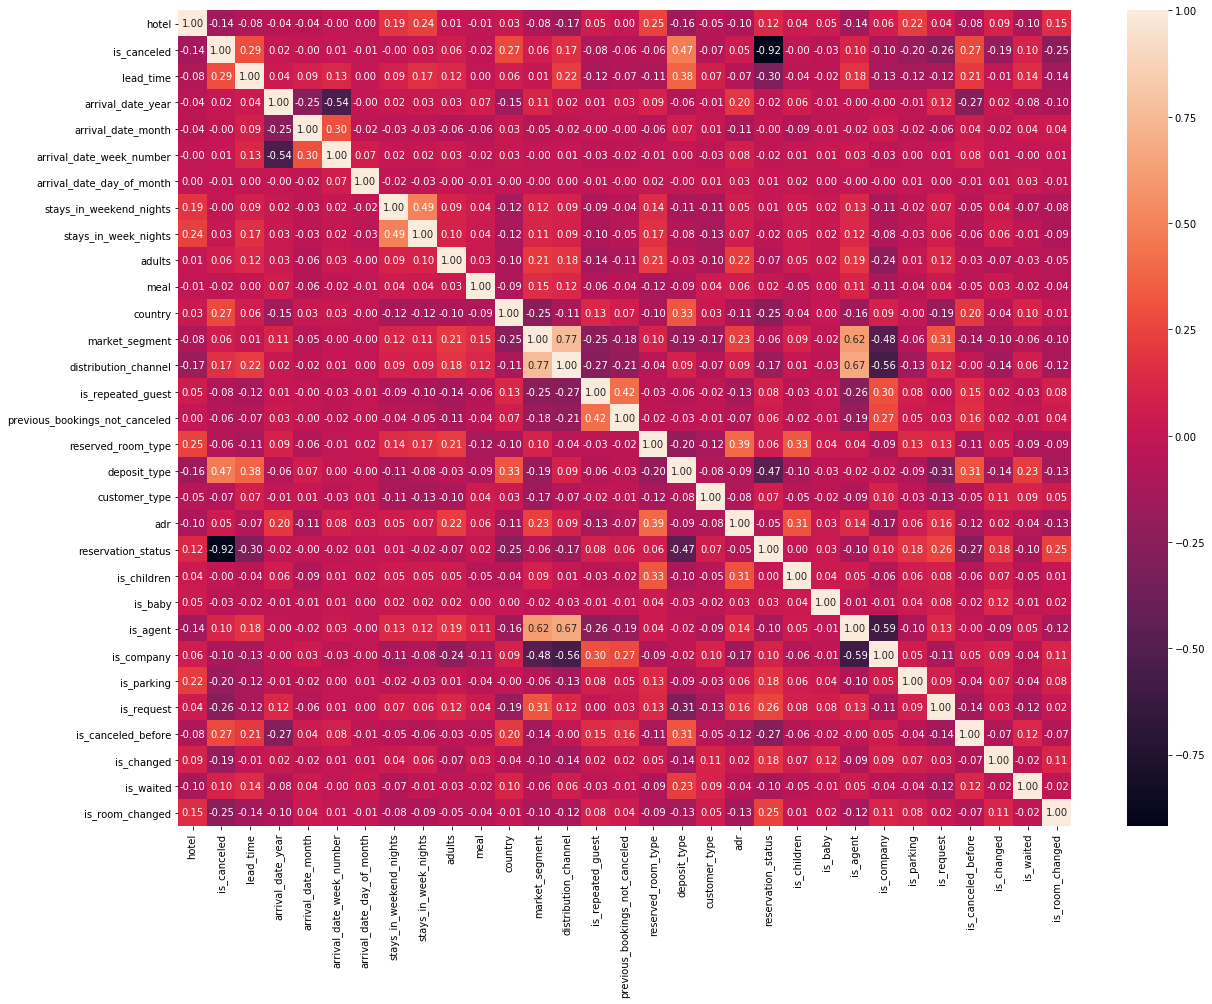

In [9]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_le.corr(), annot=True, fmt='.2f');

Vidimo da je reservation status visoko koreliran sa otkazivanje pa ćemo ga uklonit iz predviđanja otkazivanja, kao i reservation_status_date koji je povezan s njim. Također imamo visoku korelaciju između distribution_channel i market_segment pa ćemo ukloniti i market_segment.

In [10]:
columns = [
    'reservation_status_date',
    'reservation_status',
    'market_segment'
]

df1 = df1.drop(columns, axis=1)
df_le = df_le.drop(columns, axis=1)

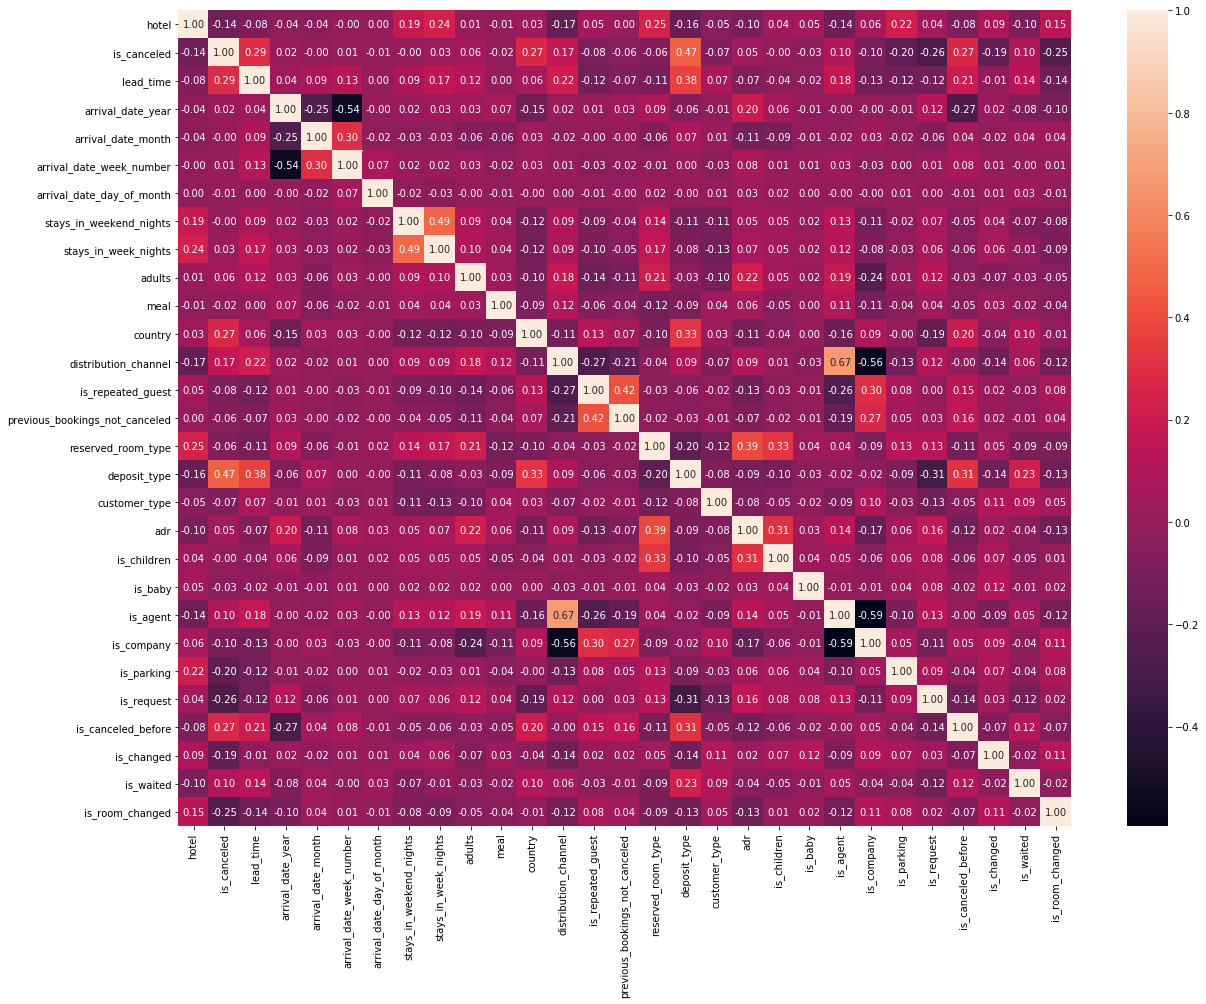

In [11]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_le.corr(), annot=True, fmt='.2f');

Nakon eliminacije reservation statusa imamo matricu korelacije u kojoj se više ni jedna vrijednost ne ističe toliko da bi ju eliminirali tako da ćemo sad preći na modeliranje sa postojećim varijablama.

In [12]:
new_categoricals = [col for col in categoricals if col in df1.columns]
df2 = pd.get_dummies(data=df1, columns=new_categoricals)

## 3. Usporedba modela i ROC krivulja

Prvo djelimo podatke na train i test set, 25% podataka ćemo nasumično izabrati za test set.

In [13]:
X = df2.drop('is_canceled', axis=1)
y = df2['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

Pripremimo funkcije model i ROC za primjenu na modelima.

In [14]:
def model(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_prob, y_pred
    y_prob = alg.predict_proba(X_test)[:,1]
    y_pred = alg_model.predict(X_test)

    print('Accuracy Score: {}\nAUC_ROC:{}'
      .format(accuracy_score(y_test,y_pred), roc_auc_score(y_test,y_pred)))
    

def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

### 3.1 Logistic Regression Model

Model: Logistic Regression

Accuracy Score: 0.8150857296245344
AUC_ROC:0.7815143978055914


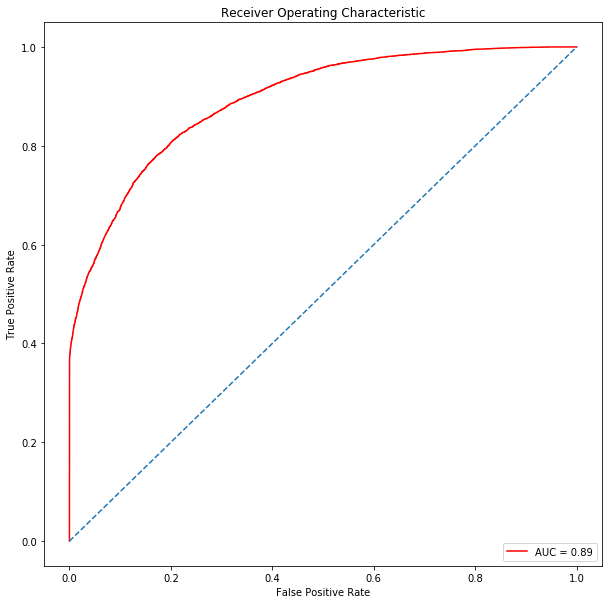

In [15]:
print('Model: Logistic Regression\n')
model(LogisticRegression(solver = "liblinear"), X_train, X_test, y_train, y_test)
ROC(y_test, y_prob)

### 3.2 Gaussian Naive Bayes Model

Model: Gaussian Naive Bayes

Accuracy Score: 0.5972553098681341
AUC_ROC:0.6638692878592338


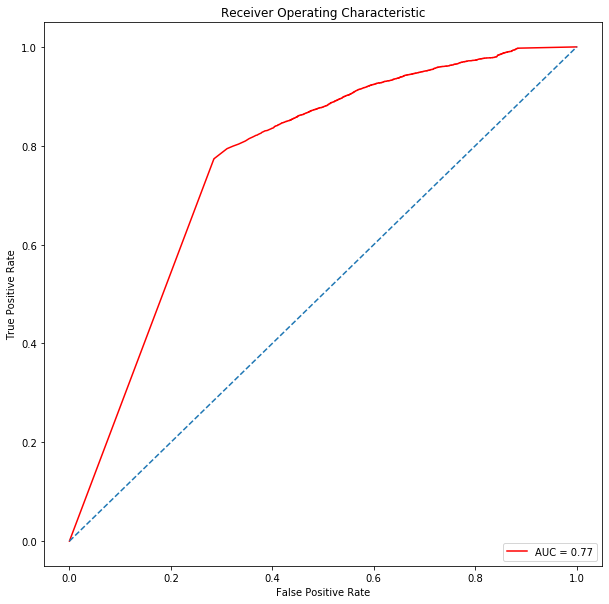

In [16]:
print('Model: Gaussian Naive Bayes\n')
model(GaussianNB(), X_train, X_test, y_train, y_test)
ROC(y_test, y_prob)

### 3.3 Decision Tree Model

Model: Decision Tree

Accuracy Score: 0.8411569305103513
AUC_ROC:0.8215054555214675


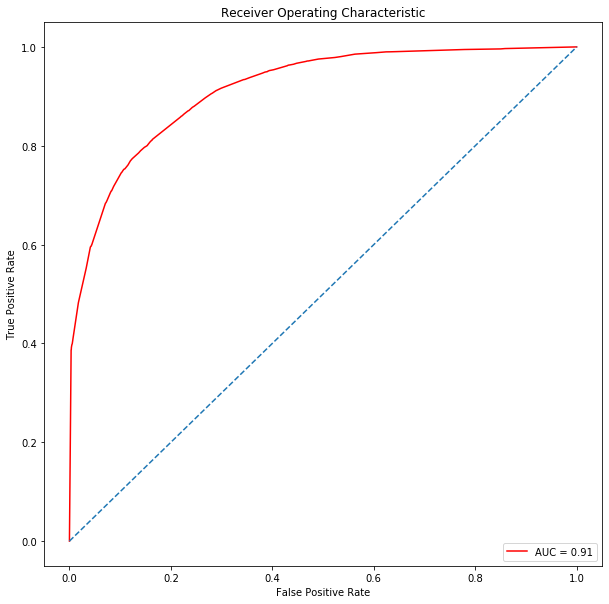

In [17]:
print('Model: Decision Tree\n')
model(DecisionTreeClassifier(max_depth = 12), X_train, X_test, y_train, y_test)
ROC(y_test, y_prob)

### 3.4 Random Forest Model

Model: Random Forest

Accuracy Score: 0.8857833104049928
AUC_ROC:0.8673140564036114


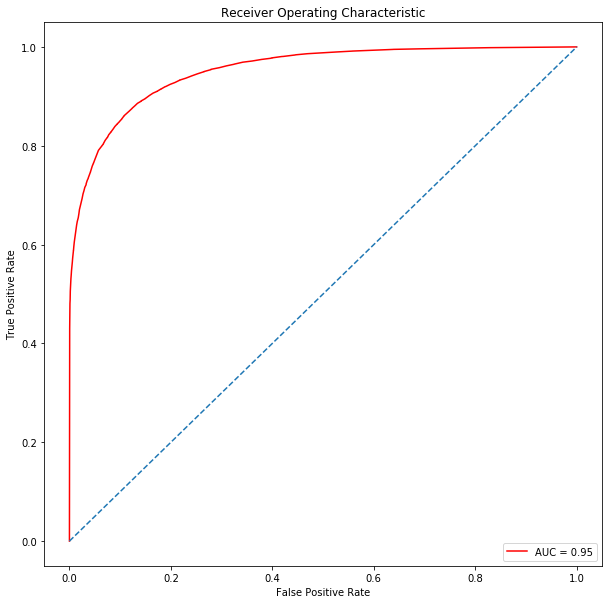

In [18]:
print('Model: Random Forest\n')
model(RandomForestClassifier(), X_train, X_test, y_train, y_test)
ROC(y_test, y_prob)

### 3.5 XGBoost Model

Model: XGBoost

Accuracy Score: 0.8346139650370769
AUC_ROC:0.8042911728072778


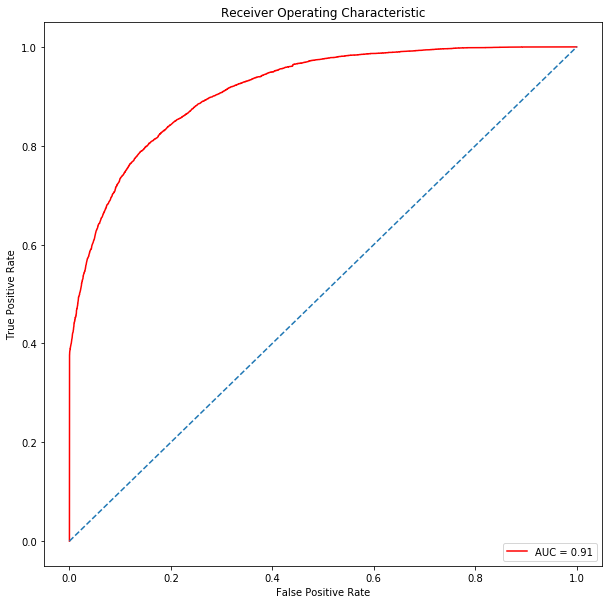

In [19]:
print('Model: XGBoost\n')
model(XGBClassifier(), X_train, X_test, y_train, y_test)
ROC(y_test, y_prob)

### 3.6 Usporedba modela 

In [20]:
table = pd.DataFrame({"Model": ["Logistic Regression", "Naive Bayes", "Decision Tree", "Random Forest", "XGBoost"],
                     "Accuracy Scores": ["0.8150", "0.5972", "0.8411", "0.8857", "0.8346"],
                     "ROC | Auc": ["0.7815", "0.6638", "0.8215", "0.8673", "0.8042"]})


table["Model"] = table["Model"].astype("category")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")
table["ROC | Auc"] = table["ROC | Auc"].astype("float32")

pd.pivot_table(table, index = ["Model"]).sort_values(by = 'Accuracy Scores', ascending=False)

,Accuracy Scores,ROC | Auc
Model,,
Random Forest,0.8857,0.8673
Decision Tree,0.8411,0.8215
XGBoost,0.8346,0.8042
Logistic Regression,0.8150,0.7815
Naive Bayes,0.5972,0.6638


Vidimo da je Random Forest najbolji model za naš primjer sa preciznošću od oko 89%, što smataramo da je dobra preciznost s obzirom da smo smanjili broj varijabli u modelu te pokušali učiniti model općenitijim zamjenom nekih varijabli. Provjeriti ćemo još mijenja li se preciznost modela ako gledamo podatke na svakom od hotela zasebno.

### 3.7 Važnost featurea kod Random Foresta

Text(0.5, 0, 'Feature Importances (%)')

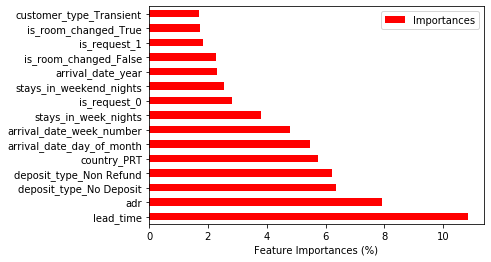

In [21]:
randomf = RandomForestClassifier()
rf_model1 = randomf.fit(X_train, y_train)

pd.DataFrame(data = rf_model1.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

Vidimo da se jedan feature ističe kao najznačajniji, to je lead_time, tj. vrijeme između datuma rezervacije i rezerviranog datuma. To smo predvidjeli i u eksploratornoj analizi. Interesantno je primjetiti da promjena sobe te prethodno otkazivanje nemaju veliki značaj u predviđanju otkazivanja što je možda iznenađujući rezultat.

### 3.8 Random Forest za svaki od hotela posebno

In [22]:
rh1 = df2.loc[(df["hotel"] == "Resort Hotel")]
ch1 = df2.loc[(df["hotel"] == "City Hotel")]

In [23]:
X_rh = rh1.drop('is_canceled', axis=1)
y_rh = rh1['is_canceled']

X_rh_train, X_rh_test, y_rh_train, y_rh_test = train_test_split(X_rh, y_rh, test_size=.25, random_state=42)

In [24]:
rf_rh = RandomForestClassifier().fit(X_rh_train, y_rh_train)

Model: Random Forest for Resort Hotel only

Accuracy Score: 0.8972233320015981
AUC_ROC:0.8549123835035437


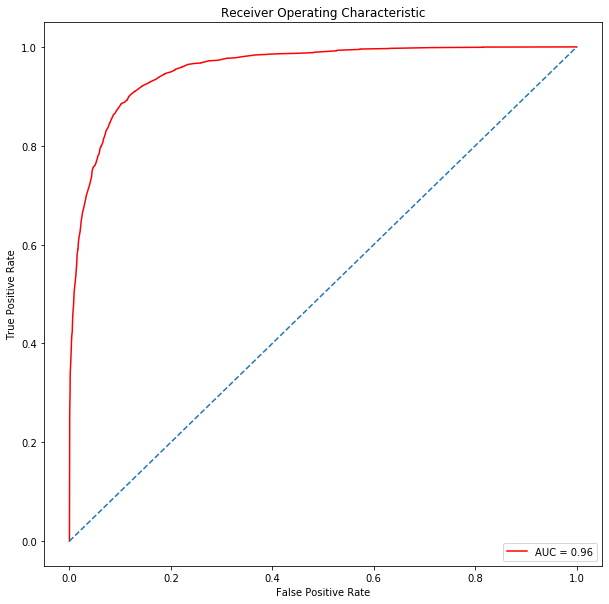

In [25]:
print('Model: Random Forest for Resort Hotel only\n')
model(RandomForestClassifier(), X_rh_train, X_rh_test, y_rh_train, y_rh_test)
ROC(y_rh_test, y_prob)

In [26]:
X_ch = ch1.drop('is_canceled', axis=1)
y_ch = ch1['is_canceled']

X_ch_train, X_ch_test, y_ch_train, y_ch_test = train_test_split(X_ch, y_ch, test_size=.2, random_state=42)

In [27]:
rf_ch = RandomForestClassifier().fit(X_ch_train, y_ch_train)

Model: Random Forest for City Hotel only

Accuracy Score: 0.8792395629381671
AUC_ROC:0.8690334273323291


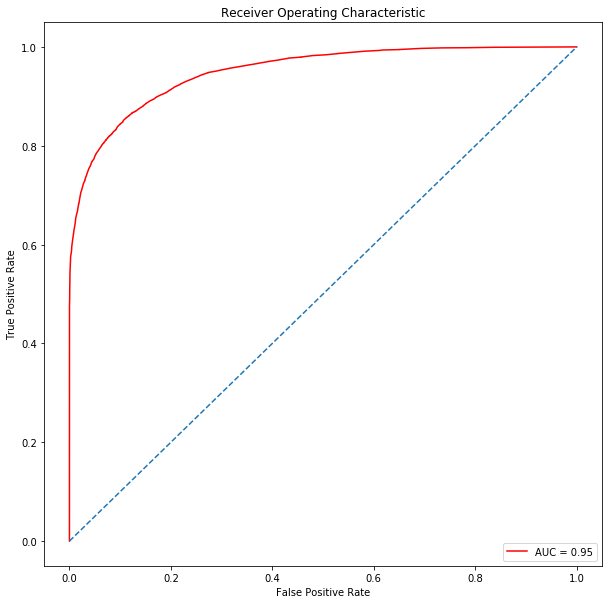

In [28]:
print('Model: Random Forest for City Hotel only\n')
model(RandomForestClassifier(), X_ch_train, X_ch_test, y_ch_train, y_ch_test)
ROC(y_ch_test, y_prob)

Vidimo da su rezultati približno jednaki kada gledamo za svaki hotel pojedinačno, razlika u preciznosti je 1% što sugerira da bi model mogao biti dovoljno općenit za primjenu i na drugim hotelima, to bi svkakako bila zanimljiva ideja za provjeriti. 